In [16]:
%matplotlib inline
import urllib2
import re
import sys
from astropy.io import fits
import numpy as np
import datetime
import time
import thread
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import subplots, show, pause, get_fignums, figure, subplot, cm
import matplotlib.patches as patches
import matplotlib.path as path
from matplotlib import gridspec
from copy import copy
import richardsplot as rplot
import gc
import palettable
from JacksTools import jio
import h5py
from collections import namedtuple
from StringIO import StringIO
from eventlet.green import urllib2 as urllibg
from eventlet import GreenPool
from functools import partial
from itertools import imap, izip
from io import BytesIO, BufferedReader
import gzip
from concurrent.futures import ThreadPoolExecutor, as_completed
from mpl_toolkits.axes_grid.inset_locator import inset_axes



# Everything down to cell 7 is imports and definitions, watch for errors!

In [49]:
def searchProposal(Proposal, campaign = 8): #Seach a proposal number for EPIC IDs, returns a dict with EPIC IDs as keys to RA and DEC coords

    socket = urllib2.urlopen('https://www.cfa.harvard.edu/~avanderb/allk2c%iobs.html' % campaign)
    body = socket.read()

    pattern = "EPIC (\d{9})</a>, Kp = (\d+\.\d+), RA = (\d+\.\d+), Dec = (-?\d+\.\d+).+%s" % Proposal
    matches = re.findall(pattern, body)
    socket.close()
    EPIC = [int(i[0]) for i in matches]
    coords = [(float(i[1]), float(i[2]), float(i[3])) for i in matches]
    Result = dict(zip(EPIC, coords))
    
    return Result

def search(target_file):
    data = jio.load(target_file, delimiter=', ', headed=True)
    EPIC = data['EPIC ID']
    RA = map(float, filter(None,data['RA (J2000) [deg]']))
    DEC = map(float, filter(None,data['Dec (J2000) [deg]']))
    MAG = map(float, filter(None,data['magnitude']))
    return {epic: (mag, ra, dec) for epic, mag, ra, dec in zip(EPIC, MAG, RA, DEC)}

def chunker(socket, CHUNK_SIZE=1024*256):
    
    chunk = socket.read(CHUNK_SIZE)
    while chunk:
        yield chunk
        chunk = socket.read(CHUNK_SIZE)


def concurrent_downloader(url):
    '''returns a file object that can be opened by astropy fits'''
    
    try:
        #socket = urllibg.urlopen(url)
        socket = urllib2.urlopen(url)
    except urllibg.URLError:
        print "Timed Out:", url
        return None
    
    raw = socket.read()
    socket.close()
        
    return url, raw

def fits_downloader(urls):
    '''Downloads multiple fits files concurrently and yields them as a generator'''
    
    #pool = GreenPool(size=20)
    pool = ThreadPoolExecutor(4)
    futures = [pool.submit(concurrent_downloader, url) for url in urls]
    #for url, raw in pool.imap(concurrent_downloader, urls):
    for r in as_completed(futures):
        url, raw = r.result()
        
        if url.endswith('.gz'): # the target pixels are compressed
            
            stream = BytesIO(raw)
            gz = gzip.GzipFile(None, 'rb', 9, stream)
            buff = BytesIO(gz.read())
            gz.close()
            
        else:
            
            buff = BytesIO(raw)
            
        hdu = fits.open(buff, cache=False)
        
        yield hdu
        
        buff.close()


def campaign_wrapper(func, campaign):
    def _wrapper(*args, **kwargs):
        return func(*(args+(campaign,)), **kwargs)
    return _wrapper

def get_vj_url(EPIC, campaign):
    EPIC = str(EPIC)
    base_url = "http://archive.stsci.edu/missions/hlsp/k2sff"
    path = "c%02i/%s00000/%s" % (campaign, EPIC[:4], EPIC[4:])
    base_name = "hlsp_k2sff_k2_lightcurve_%s-c%02i_kepler_v1_llc.fits" % (EPIC, campaign)
    filename = '/'.join((base_url, path, base_name))
    return filename

def get_everest_url(EPIC, campaign):
    EPIC = str(EPIC)
    base_url = "https://archive.stsci.edu/hlsps/everest/v2"
    path = "c%02i/%s00000/%s" % (campaign, EPIC[:4], EPIC[4:])
    base_name = "hlsp_everest_k2_llc_%s-c%02i_kepler_v2.0_lc.fits" % (EPIC, campaign)
    filename = '/'.join((base_url, path, base_name))
    return filename

def get_target_pixel_url(EPIC, campaign):
    
    base_url = 'https://archive.stsci.edu/missions/k2/target_pixel_files/'
    path = 'c%i/%i00000/%02i000/' % (campaign, EPIC / 100000, (EPIC % 100000)/1000)
    filename = 'ktwo%i-c%02i_lpd-targ.fits.gz' % (EPIC, campaign)
    url = base_url + path + filename
    return url
    
def downloadVJ(EPIC, campaign):
    EPIC = str(EPIC)
    base_url = "http://archive.stsci.edu/missions/hlsp/k2sff"
    path = "c%02i/%s00000/%s" % (campaign, EPIC[:4], EPIC[4:])
    base_name = "hlsp_k2sff_k2_lightcurve_%s-c%02i_kepler_v1_llc.fits" % (EPIC, campaign)
    filename = '/'.join((base_url, path, base_name))
    for i in xrange(5): #Timeouts are common, just need to retry
        try:
            #Set memmap and cache to False if you get an error about too many open files
            hdulist = fits.open(filename, memmap = None, cache = True)
            return hdulist
        except urllib2.URLError:
            print "Timeout Error, Retrying: Attempt %i/5" % (i+1)
            if not (i+1) % 5:
                print "LC Download Failed, Will Continue Without %s" % str(EPIC)
    return None

def download_target_pixels(EPIC, campaign):

    base_url = 'https://archive.stsci.edu/missions/k2/target_pixel_files/'
    path = 'c%i/%i00000/%02i000/' % (campaign, EPIC / 100000, (EPIC % 100000)/1000)
    filename = 'ktwo%i-c%02i_lpd-targ.fits.gz' % (EPIC, campaign)
    url = base_url + path + filename
    #print url # print if verbose
    hdu = fits.open(url, memmap=None, cache=None)
    return hdu

In [18]:
# Some data conversion scripts

def magToFlux(mag):
    return 10**(-0.4*(mag-12))*1.74e5

#Do some Download Tests
objs = searchProposal("GO", 8).keys()
c8pixels = campaign_wrapper(get_target_pixel_url, 8)
urls = imap(c8pixels, objs[:2])
for i in fits_downloader(urls):
    print i.info()
    i.close()

In [19]:
'''
K2FOV.py - Tools for working with k2 fields

Author: Jack O'Brien
Date: 10/19/2017

Execution: python 2.7
Requires: numpy, matplotlib, JacksTools

Usage:
    Can plot a field from a campaign
    Can determine if an object lies within a field
    Tools for placing objects within a k2 campaign field
'''
import os
#BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = "../"

try:

    from JacksTools import jio
except ImportError as e:
    print("Please install JacksTools")
    print("$ pip install JacksTools")
    raise ImportError
import numpy as np
from matplotlib.pyplot import subplots, show

FOOTPRINT_FILE=os.path.join(BASE_DIR,"data/k2-footprint.csv")

class Field:
    ''' A single K2 campaign feild
        Relevant methods for end user:
            plot_field
            test_point
    This thing sort of works as a state machine underneath
    '''
    data = jio.load(FOOTPRINT_FILE, headed=True, delimiter=',')
    # This array of tuples iterates over adjacent edges of a square
    grouping = zip(np.arange(4), (np.arange(4)+1)%4)

    def __init__(self, campaign, cache_data=True):

        self.campaign = campaign
        self.cache = cache_data
        self.footprint = self._get_campaign(campaign)
        self.length = len(self.footprint)
        self.ra = np.array([self.footprint['ra'+i] for i in '0123'])
        self.dec = np.array([self.footprint['dec'+i] for i in '0123'])
        self.bounding_box = self.__get_bounding_box()
        self.bbox_set = tuple(map(self.__get_bounding_box, xrange(len(self))))
        mask = self.footprint['module'] == 13 # Module 13 is the center module
        self.center = {'ra':np.mean(self.ra[:,mask]), 'dec':np.mean(self.dec[:,mask])}

    def plot_field(self, ax, label=False): # TODO: update this to use self.ra and self.dec
        ''' plot the footprint on an axis '''
        fp = self.footprint # For shorter typing 
        sqr = np.arange(5)%4 # indeces of box corners
        for idx, ccd in enumerate(self): # Iterate over the CCDs
            # Grab the box corners, complete the shape by repeating first term
            ax.plot(self.ra[sqr, idx], self.dec[sqr, idx], color='k', lw=1)
        if label: # You can set the label to True or a string
            if type(label) is bool:
                label="Campaign %i" % self.campaign
            ax.text(self.center['ra'], self.center['dec'], str(self.campaign), fontsize = 25)

    def test_point(self, ra, dec):
        ''' test if a point is inside a field, return the channel number '''

        top, right, bottom, left = self.bounding_box
        if not (left < ra < right) or not (bottom < dec < top): #Check Full Field bbox
            return 0,0
        for idx, ccd in enumerate(self): # Iterate over the channels
            top, right, bottom, left = self.bbox_set[idx]
            if left < ra < right and bottom < dec < top: #Check channel bbox
                test = self.__test_channel(idx, ra, dec)
                t0 = test.next() # Get the first truth value
                for t in test:
                    if t is not t0: # All we care about is all elements are uniform
                        break
                else:
                    return ccd['module'], ccd['channel'] #NOTE: THIS WAS CHANNEL BEFORE
        return 0,0

    @classmethod
    def get_channels(self, module):
        '''get the channel numbers associated with the module'''
        return sorted(list(set(self.data['channel'][self.data['module'] == module])))
    
    @classmethod
    def get_module(self, channel):
        '''get the module associated with a channel'''
        return self.data['module'][self.data['channel'] == channel][0]
    
    @classmethod
    def get_modules(self):
        return sorted(list(set(self.data['module'])))
    
    @classmethod
    def _get_campaign(self, campaign):
        ''' get the footprint of a campaign '''
        fp = self.data[self.data['campaign'] == campaign]
        # Place RA on scale from -180 to 180 in degrees
        if any(ra > 180 for i in '0123' for ra in fp['ra'+i]):
            for i in '0123': fp['ra'+i][::] -= 360
        return fp

    def __test_channel(self, idx, ra, dec):
        ''' Test if a point at ra and dec are within the bbox of a channel 
            This works by taking vectors describing the channel edges and
            taking the cross product with a vector defined by the point relative
            to the first point in the edge vector.  If the cross product of these
            vectors is the same sign for all edges, then the point must be contained
            within the box.  This method is a generator which yeilds a boolean
            describing the sign of the cross product (True for positive, 
            False for negative)
        '''
        ccd_ra, ccd_dec = self.ra[:,idx], self.dec[:,idx]
        for i,j in self.grouping:
            # Compute the edge vector
            dra, ddec = ccd_ra[j] - ccd_ra[i], ccd_dec[j] - ccd_dec[i]
            # Compute the point to vertex vector
            dpra, dpdec = ra - ccd_ra[i], dec - ccd_dec[i]
            # Compute the cross product
            pos = dra*dpdec - ddec*dpra
            yield pos > 0

    def __get_bounding_box(self, idx=None):
        ''' get a box that bounds the edge of the field (t,r,b,l)'''
        if idx is None:
            ra, dec = self.ra, self.dec
        else:
            ra, dec = self.ra[:,idx], self.dec[:,idx]
        top = dec.max()
        right = ra.max()
        bottom = dec.min()
        left = ra.min()
        return top, right, bottom, left

    def __len__(self):
        ''' just get the number of elements in the footprint '''
        return self.length

    def __iter__(self):
        ''' iterate over elements of the footprint list '''
        for ccd in self.footprint:
            yield ccd


In [20]:

class DummyModule(object):
    def __init__(self, params):
        self.__dict__.update(params)
        
K2FOV = DummyModule({'Field':Field})
downloader = DummyModule({'downloadVJ':downloadVJ,
                          'download_target_pixels':download_target_pixels})
class LoadingBar:


    def __init__(self):

        self.is_running = True
        #self.mapping = '_.-^-.'
        self.mapping = '-/|\\'
        self.N = len(self.mapping)
        self.n = self.N*2
        self.n = 1
        self.blank = (' '*(self.n+2)).join('\r\r')
        self.done = False
        self.clock = 0
        self.prev_est = []
        self.percentage_est = 0

        
    def print_loading_bar(self):

        N = self.N
        n = self.n
        while self.is_running:
            for j in xrange(N):
                sys.stdout.write(self.blank)
                for i in xrange(j,j+n):
                    sys.stdout.write('('+self.mapping[i%N]+')')
                sys.stdout.flush()
                if not self.is_running:
                    self.done = True
                    break
                time.sleep(0.1)
        self.done=True
        
    def print_bar(self):
        
        self.N = 60
        self.blank = (" "*(self.N+20)).join("\r\r")
        while self.is_running:
            t_remain = self.est_remaining()
            for j in xrange(len(self.mapping)):
                sys.stdout.write(self.blank)
                string = "[" + "#"*self.n +self.mapping[j] + '.'*(self.N-1-self.n) + "] " + t_remain
                sys.stdout.write(string)
                sys.stdout.flush()
                if not self.is_running:
                    self.done = True
                    break
                time.sleep(0.1)
        self.done = True
        
    def est_remaining(self):
        
        
        if self.percentage_est != 0:
            if self.n == self.N:
                return "Done"
            delta = time.time() - self.clock
            p = self.percentage_est
            est = delta/p*(1-p)
            self.prev_est.append(est)
            max_terms = (min((self.N-self.n, self.n))+1)*4
            min_terms = 30 # central limit theorem!
            if self.n > self.N / 2:
                min_terms = 1
            
            while len(self.prev_est) > max_terms:
                self.prev_est.pop(0)
            if len(self.prev_est) > min_terms:
                now = copy(self.prev_est)
                weights = np.linspace(0,2,len(now)) # weight the estimates linearly
                # for the weight function, I can chose anything as long as it integrates to 1
                # to make sure this happens, I can just divide by the sum
                weights[::] = np.exp(weights)
                weights /= (np.sum(weights)/len(now))
                est = int(np.mean(np.array(now)*weights))
                return "{}:{:02d} remaining".format(est/60, est%60)
        return "Estimating..."
        
    def set_as_bar(self):
        
        self.print_loading_bar = self.print_bar
        
    
    def update_bar(self, percentage):
        
        self.n = int(percentage * self.N)
        self.percentage_est = percentage
        self.est_remaining() # This will update our estimate faster

    def __enter__(self):

        self.clock = time.time()
        self.prev_est = []
        self.percentage_est = 0
        self.done=False
        self.is_running=True
        thread.start_new_thread(self.print_loading_bar, ())
        return self

    def __exit__(self, *args):

        self.n = self.N
        self.is_running = False
        while not self.done:
            time.sleep(0.001)
        sys.stdout.write(self.blank)
        sys.stdout.flush()
        self.n = 1
        self.clock = 0


In [21]:
# Now we'll look at functions for extracting target pixels based on the module

def moduleFilter(ccd):
    K2FOV = Field(ccd.campaign)
    channel = Field.get_channels(ccd.module)[ccd.channel]
    def _filter(item):
        ra, dec = item[1][1:]
        mod, chan = K2FOV.test_point(ra,dec)
        return (ccd.module == mod) and (chan == channel)
    return _filter


def getObjects(ccd):
    '''input arg "channel" now refers to an index 0-3'''
    channel = Field.get_channels(ccd.module)[ccd.channel]
    objs = searchProposal("GO", ccd.campaign)
    objs = dict(filter(moduleFilter(ccd), objs.iteritems()))
    return objs

#Grab the target pixels (or at least see if the computer can handle them)
#Note: check for pixel overlap when creating full map
# Don't do all the downloading at once

def getPixels(epics, campaign):
    '''Download lots of target pixel files as a generator'''
    
    pixel_url_generator = campaign_wrapper(get_target_pixel_url, campaign)
    urls = imap(pixel_url_generator, epics)
    for hdu in fits_downloader(urls):
        yield hdu


In [22]:
# Select here for flux or raw counts in the pixels
#DATA="FLUX"
DATA="RAW_CNTS"


CCD = namedtuple('CCD', ['module', 'channel', 'field', 'campaign'], verbose=False)

class BasicFitsContainer:
    
    def __init__(self, hdu, field, **kwargs):
        if hdu is not None:
            self.pixels = np.array(copy(hdu[1].data[field]))
            self.m, self.n = self.pixels[0].shape #WARNING! I swapped n and m, make sure that is right (it is)
            self.col = hdu[1].header['1CRV9P']
            self.row = hdu[1].header['2CRV9P']
            #print self.row, self.row+self.m, self.col, self.col+self.n, np.sum(self.pixels[0])
            del hdu[1].data
            del hdu
        else:
            self.__dict__.update(kwargs)
        
class PixelMapContainer:
    
    def __init__(self, ccd, bar = None, init=True, generator=False):
        self.ccd = ccd
        self.containers = []
        self.objs = {}
        self.isgenerator = generator
        if init:
            self.objs.update(getObjects(ccd))
            if not self.isgenerator:
                self.load(bar)

                

    def load(self, bar=None):
                
        for i, hdu in enumerate(getPixels(self.objs.iterkeys(), self.ccd.campaign)):
            if bar is not None:
                bar.update_bar(1.0*i/len(self.objs.keys()))
            self.containers.append(BasicFitsContainer(hdu, self.ccd.field))
            hdu.close()
            del hdu
            gc.collect()

    def __getitem__(self, i):
        return self.containers[i]
    
    def __len__(self):
        return len(self.objs.keys())

    def __iter__(self):
        if self.isgenerator:
            for hdu in getPixels(self.objs.iterkeys(), self.ccd.campaign):
                yield BasicFitsContainer(hdu, self.ccd.field)
                hdu.close()
                del hdu
                gc.collect()
        else:
            for c in self.containers:
                yield c
        
class PixMapGenerator:
        
    def __init__(self, PixContainer, cache=False):
        
        self.buff = np.zeros((1150,1150), dtype=np.float64)
        self.containers = PixContainer.containers
        self.ccd = PixContainer.ccd
        self.stats = None
        self.cache = cache # should we cache returned items
        if cache:
            self.pixel_distribution_buffered = [False]*N
            self.pixel_distribution = [0]*N

        
    def __iter__(self):
        for i in xrange(N):
            yield self[i]
            
    def __len__(self):
        return len(self.containers)
            
    def build_stats_cache(self):
        self.stats = {'std':[],'med':[],'mean':[]}
        for c in self.containers:
            data = copy(c.pixels*1.0)
            if DATA == 'RAW_CNTS':
                data[data <= 0.5] = np.nan
            data = np.log10(data)
            self.stats["std"].append(np.nanstd(data, axis=0))
            #print "D0, std, std",data[0], self.stats['std'][-1], np.nanstd(data, axis=0)
            self.stats["med"].append(np.nanmedian(data, axis=0))
            self.stats["mean"].append(np.nanmean(data, axis=0))
            del data
            
    def get_zscore(self, i):
        if self.stats is None:
            self.build_stats_cache()
        self.buff[::] = np.nan
        for j,c in enumerate(self.containers): #Maybe I can do this in parallel?
            data = np.log10(copy(c.pixels[i])*1.0)
            if DATA == 'RAW_CNTS':
                data[np.isnan(data)] = self.stats['med'][j][np.isnan(data)]
                data[~np.isfinite(data)] = self.stats['med'][j][~np.isfinite(data)]
            frame = (data - self.stats['med'][j])/self.stats['std'][j]
            self.buff[c.row:c.row+c.m,c.col:c.col+c.n] = frame
        del frame
        del data
        return self.buff
    
    def get_unordered(self,i):
        if self.cache:
            if not self.pixel_distribution_buffered[i]:
                self.pixel_distribution[i] = np.concatenate([c.pixels[i][~np.isnan(c.pixels[i])].flat for c in self.containers])
                self.pixel_distribution_buffered[i] = True
            return self.pixel_distribution[i]
        else:
            return np.concatenate([c.pixels[i][~np.isnan(c.pixels[i])].flat for c in self.containers])

            
    def __getitem__(self, i):
        self.buff[::] = np.nan
        for c in self.containers: #Maybe I can do this in parallel?
            try:
                self.buff[c.row:c.row+c.m,c.col:c.col+c.n] = c.pixels[i]
            except Exception as e:
                print e
                print "ERROR"
                print c.row+c.m, c.col+c.n
        return self.buff

In [23]:
def bin_pixel_buffer(buff, new_shape):
    m, n = new_shape
    r, c = buff.shape
    n_row = int(r/m)
    n_col = int(c/n)
    new_buff = np.zeros(new_shape)
    for i in xrange(m):
        for j in xrange(n):
            new_buff[i, j] = np.nanmedian(buff[i*n_row:(i+1)*n_row, j*n_col: (j+1)*n_col])
    return new_buff

def thread_return(func, *args, **kwargs):
    
    arr = []
    def run_in_thread():
        arr.append(func(*args, **kwargs))
    thread.start_new_thread(run_in_thread, ())
    return arr

In [24]:
'module', 'channel', 'field', 'campaign'

def make_pixel_map_name(ccd):
    mo, ch, fi, ca = ccd
    assert fi in ["FLUX", "RAW_CNTS"]
    return "K2c{}m{}ch{}_{}".format(ca, mo, ch, "flux" if fi == "FLUX" else "raw")


def save_pixel_map(ccd):
    loader = LoadingBar()
    loader.set_as_bar()
    hdf5_file = "../data/PixelMaps/K2PixelMap.hdf5"
    group_name = make_pixel_map_name(ccd)
    with h5py.File(hdf5_file, 'a') as f:
        print("  Generating Target Pixel Container...")
        with loader:
            cont = PixelMapContainer(ccd, generator=True)
        print("  Writing...")
        with loader:
            for i, g in enumerate(cont):
                dset=None
                name = "/".join((group_name, str(i)))
                if name not in f:
                    f.create_dataset(name+'/idx', data=np.array([g.m,g.n,g.row,g.col]))
                    f.create_dataset(name+'/data', data=g.pixels)
                loader.update_bar(i*1.0/len(cont))
            loader.update_bar(1)
        del cont
    return ccd
            
def load_pixel_map(ccd):
    '''Returns a PixelMapContainer'''
    loader = LoadingBar()
    loader.set_as_bar()
    hdf5_file = "../data/PixelMaps/K2PixelMap.hdf5"
    group_name = make_pixel_map_name(ccd)
    with h5py.File(hdf5_file,'a') as f:
        if group_name not in f:
            f.close()
            print("Creating new hdf5 entry...")
            return load_pixel_map(save_pixel_map(ccd))
        cont = PixelMapContainer(ccd, init=False)
        with loader:
            group = f[group_name]
            for i,name in enumerate(group):
                loader.update_bar(1.0*i/len(group))
                pixels = np.array(group[name]['data'])
                m,n,row,col = np.array(group[name]['idx'])
                hdu = BasicFitsContainer(None, None, pixels=pixels, m=m, n=n, row=row, col=col)
                cont.containers.append(hdu)
            loader.update_bar(1)
    gc.collect()
    return cont

In [25]:
#From here on are our programs

In [26]:
# Some user settings
#field = 'RAW_CNTS'
field = 'FLUX'
campaign = 8
#module=4
#channel=3 #Index of the channel

#module = 17 #This is the next one, on the dwarf galaxy, hopefully lots of objects
#channel = 1

channel=2
module=16

N=3853 # The total number of available frames
#N=2353

ccd = CCD(campaign=campaign, field=field, channel=channel, module=module)

objs = getObjects(ccd) # Dictionary of objects
print "Channel From File:",Field.get_channels(ccd.module)[ccd.channel]
print "Number of Objects:",len(objs.items())
loader = LoadingBar()
loader.set_as_bar()

Channel From File: 55
Number of Objects: 310


In [27]:
#save_pixel_map(channel, module, campaign, field)
cont = load_pixel_map(ccd)

In [28]:
gen=PixMapGenerator(cont, cache=True)

In [29]:
#data = np.concatenate([gen.get_unordered(i) for i in xrange(N)])

In [30]:
#Lets make some histograms of pixel frames!

#fig, ax = subplots(1,1, figsize=(12,8))
#n, bins, patches = ax.hist(np.log10(data), bins = 1000, histtype='stepfilled', range=(-6,6))

#percentiles = percentile_range(10)
#for p in percentiles:
#    print p
#    m = percentile_mask(*p)
#    d = data[m(data)]
#    _,_,_, = ax.hist(np.log10(d), bins = bins, range=(-6,6), histtype='stepfilled')




In [86]:
def draw_pixel_lc(gen, func, mask_func, ax=None, normed=False, corrected=False, artist=None):
    units = 'mJy' if field == 'FLUX' else 'Counts'
    ccd = gen.ccd
    if ax is None:
        fig, ax = subplots(1,1, figsize=(12,6.75))
        fig.suptitle("K2 Module %i, Channel %i, Median Pixel LC" % (ccd.module, ccd.channel))
        ax.set_xlabel("Observation Number")
        ax.set_ylabel(field.replace('_',"\_")+"\ ({})".format(units if not normed else "Arbitrary Units"))

    lc = np.empty(N)
    lc[::] = np.nan

    for i,g in enumerate((gen.get_unordered(i) for i in xrange(N))):
        if not np.isnan(g).all():
            mask = mask_func(g)
            cut = g[mask]
            val = func(cut)
            if val:
                lc[i] = val
    
    stats = {'mean':np.nanmean(lc), 'max':np.nanmax(lc), 'min':np.nanmin(lc)}
                
    if normed or corrected:               
        mean = np.nanmean(lc)
        tmean = mean # mean used in the title
        if normed:
            lc /= mean
            mean=1.0
        if corrected:
            std = np.nanstd(lc)
            lc[(mean-2*std > lc) | (lc > mean+2*std)] = np.nan
    if artist is None:
        artist, = ax.plot(np.arange(len(lc)), lc, marker='.', label=mask_func.__doc__, ms=1, ls=' ', animated=True)
        ax.set_xlim(0,len(lc))
    else:
        artist.set_data(np.arange(len(lc)),lc)
        ax.set_title(mask_func.__doc__)
        ax.autoscale(True, True, True)
        ax.autoscale_view(True, True, True)

    title = mask_func.__doc__
    if normed:
        title += ', Mean: {:>9.2f} {}'.format(tmean, units).replace(' ','\ ')
    ax.set_title(title)
    
    

    return ax.figure, ax, artist, stats
    
def percentile_mask(lower, upper):
    def _percentile_mask(data):
        if field == 'RAW_CNTS':
            if len(data[data>0]):
                low, up = np.nanpercentile(data[data>0],[lower,upper])
            else:
                low, up = -np.inf, np.inf
            return (low < data) & (data < up) & (data > 0)
        low, up = np.nanpercentile(data,[lower,upper])
        return (low < data) & (data < up)
    _percentile_mask.__doc__ = '''{0:>4.1f}\% to {1:>5.1f}\%'''.format(lower, upper).replace(' ','\ ')
    return _percentile_mask

def percentile_range(N, off=0):
    edges = np.linspace(0.0+off,100.0+off,N+1)
    return zip(edges[:-1],edges[1:])

def smooth_percentile_range(N):
    z1 = percentile_range(N)
    z2 = percentile_range(N, off=50.0/N)
    return [z1[i/2] if not i%2 else z2[i/2] for i in xrange(N*2-1)]

ax = None
line=None
fig=None
def make_lc_animation(gen, percentiles):
    global ax, line, fig
    ax = None
    line = None
    fig = None
    fig, ax, line = draw_pixel_lc(gen, np.median, percentile_mask(*percentiles[0]), ax=ax, normed=True, corrected=True, artist=line)
    
    def update(i):
        global ax, line, fig
        if not i % 5:
            i = i/5
            loader.update_bar(1.0*i/len(percentiles))
            fig, ax, line = draw_pixel_lc(gen, np.median, percentile_mask(*percentiles[i]), ax=ax, normed=True, corrected=True, artist=line)
            loader.update_bar(1.0*(i+1)/len(percentiles))
        return line,

    print("Initializing...")
    anim = animation.FuncAnimation(fig, update, frames=len(percentiles)*5, interval=100, blit=True)
    print("Ready to Process")
    return anim
    



In [135]:
# will do the inset plots here

ccd = CCD(campaign=8, field='FLUX', module=16, channel=2)
cont = load_pixel_map(ccd)
gen = PixMapGenerator(cont)



In [95]:
f_data = np.array(fluxes.values())
print min(*f_data), max(*f_data), np.mean(f_data), np.std(f_data)

0.100126549097 60221.1782345 284.869488576 3427.94914795


In [99]:
means = [(-3.2897882461547852, 193.027587890625, -1.8158015169698047),
 (0.36172914505004883, 198.09201049804688, 1.3802208158963671),
 (2.8156552314758301, 201.99847412109375, 4.1782793395221232),
 (5.8093762397766113, 207.16531372070312, 8.1919636162618801),
 (10.720529556274414, 215.72616577148438, 15.049986236790817),
 (20.205961227416992, 232.52171325683594, 28.502446700135867),
 (42.325481414794922, 269.712890625, 58.493052932620046),
 (105.41973876953125, 527.1002197265625, 139.43757717410725),
 (378.66827392578125, 1448.89208984375, 484.86084570089974),
 (3340.397705078125, 13731.6796875, 3847.5657582600911)]
obj_range = []
best_obj = []
for low, high, mean in means:
    obj_range.append([(key,fluxes[key]) for key in fluxes.iterkeys() if low < fluxes[key] < high])
    items = obj_range[-1]
    fs = zip(*items)[1]
    #print items
    best_obj.append(items[np.argmin(np.abs(np.array(fs)-mean))])
    
print best_obj

[(229228984, 0.10012654909666516), (220175392, 1.3821311284202495), (220170179, 4.480734883313942), (220168802, 8.168630437257084), (220166077, 14.905592647120818), (220157465, 27.98654249374409), (220160392, 58.74207024484402), (220177583, 137.07215740790826), (220160375, 494.9362326959373), (220168379, 5431.868508875813)]


In [ ]:
NP = 2
percentiles = percentile_range(NP)
pmask = (percentile_mask(*p) for p in percentiles)
stat_list = []
bboxes = [(150,120,500,100),(150,180,500,100)]
print "Initializing Plots"
loader = LoadingBar()
loader.set_as_bar()
with loader as f:
    for i, mask in enumerate(pmask):
    
        fig,ax,_,stats = draw_pixel_lc(gen, np.median, mask, normed=True, corrected=True)
        #'''
        stat_list.append([ax,stats])
        f.update_bar(1.0*i/NP)
    
axes, means = zip(*stat_list)

objs = searchProposal('GO', 8)
filt = moduleFilter(ccd)
in_ccd = dict(filter(filt, objs.items()))
fluxes = {key:magToFlux(values[0])/1000.0 for key, values in in_ccd.iteritems()}
print "Getting Objects"
obj_range = []
best_obj = []
for low, high, mean in [(m['min'], m['max'], m['mean']) for m in means]:
    obj_range.append([(key,fluxes[key]) for key in fluxes.iterkeys() if low < fluxes[key] < high])
    items = obj_range[-1]
    fs = zip(*items)[1]
    best_obj.append(items[np.argmin(np.abs(np.array(fs)-mean))])
    
print "Plotting Objects" 
for ax in axes:
    ax2 = inset_axes(ax,
                    width="60%", # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    loc=1)
    obj, f_base = best_obj[i]
    VJ = downloadVJ(obj, 8)
    data = VJ[1].data
    t = data['T']
    flux = data['FCOR']
    flux *= f_base
    # do some cleaning up of the data
    std = np.nanstd(flux)
    m = np.nanmean(flux)
    flux[(flux > m + 2 * std) | (flux < m - 2 * std)] = np.nan

    ax2.plot(np.arange(len(t)), flux, marker='.', ls=' ', ms=0.5)
    ax2.set_title('EPIC\ '+str(obj))
    ax2.set_ylabel('Flux\ (mJy)')
    ax2.set_xlabel('Observation Number')
    VJ.close()

    #break

    #'''

    

Initializing Plots
[\...........................................................] Estimating...    

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


({'max': 201.99847412109375, 'min': 2.8156552314758301, 'mean': 4.1782561247547472}, {'max': 527.1002197265625, 'min': 105.41973876953125, 'mean': 139.4387631813685})


In [ ]:
ranges = [(s['min'], s['max'], s['mean']) for s in stat_list]
ranges

CCD(module=2, channel=0, field='FLUX', campaign=8)
  File Already Exists
CCD(module=2, channel=1, field='FLUX', campaign=8)
  File Already Exists
CCD(module=2, channel=2, field='FLUX', campaign=8)
  File Already Exists
CCD(module=4, channel=0, field='FLUX', campaign=8)
  File Already Exists
CCD(module=4, channel=1, field='FLUX', campaign=8)
  File Already Exists
CCD(module=4, channel=2, field='FLUX', campaign=8)
  File Already Exists
CCD(module=6, channel=0, field='FLUX', campaign=8)
  File Already Exists
CCD(module=6, channel=1, field='FLUX', campaign=8)
  File Already Exists
CCD(module=6, channel=2, field='FLUX', campaign=8)
  File Already Exists
CCD(module=8, channel=0, field='FLUX', campaign=8)
  File Already Exists
CCD(module=8, channel=1, field='FLUX', campaign=8)
  File Already Exists
CCD(module=8, channel=2, field='FLUX', campaign=8)
  File Already Exists
CCD(module=9, channel=0, field='FLUX', campaign=8)
  Number of Objects: 335
Creating new hdf5 entry...
  Generating Target P

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


Initializing...
Ready to Process
  Saving...[#-..........................................................] Estimating...
CCD(module=9, channel=1, field='FLUX', campaign=8)                              
  Number of Objects: 312
Creating new hdf5 entry...
  Generating Target Pixel Container...
  Writing...                                                                    
Initializing...                                                                 
Ready to Process
                                                                                
CCD(module=9, channel=2, field='FLUX', campaign=8)                              
  Number of Objects: 316
Creating new hdf5 entry...
  Generating Target Pixel Container...
  Writing...                                                                    
Initializing...                                                                 
Ready to Process
  Saving...
CCD(module=10, channel=0, field='FLUX', campaign=8)                             
  N

KeyboardInterrupt: 

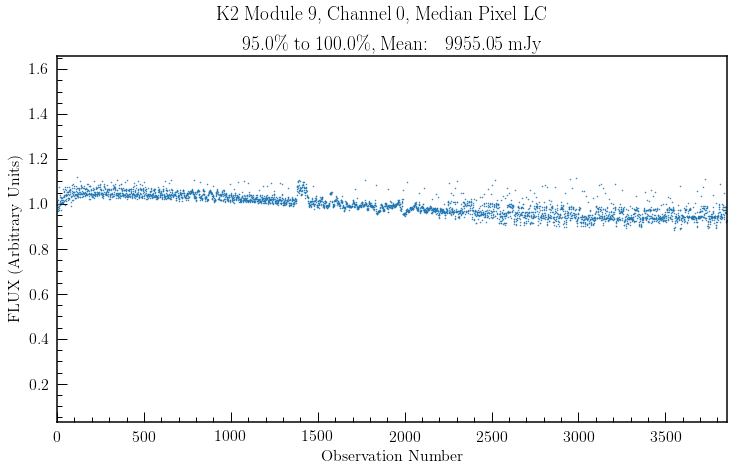

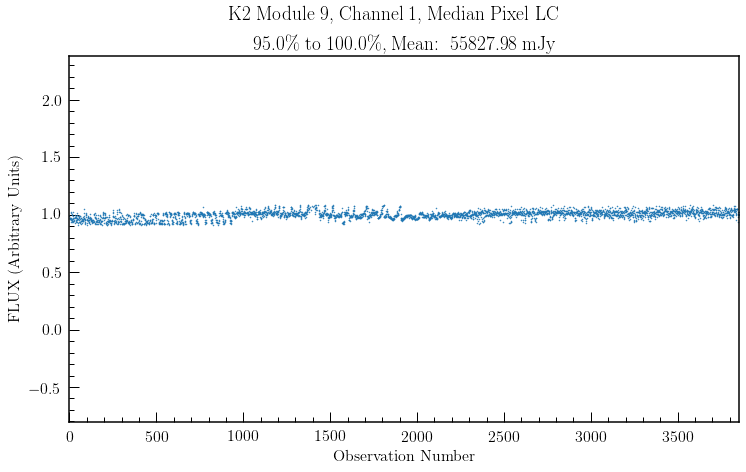

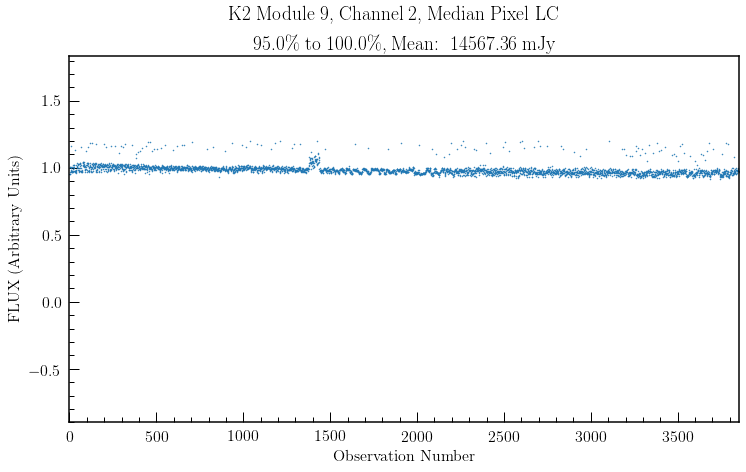

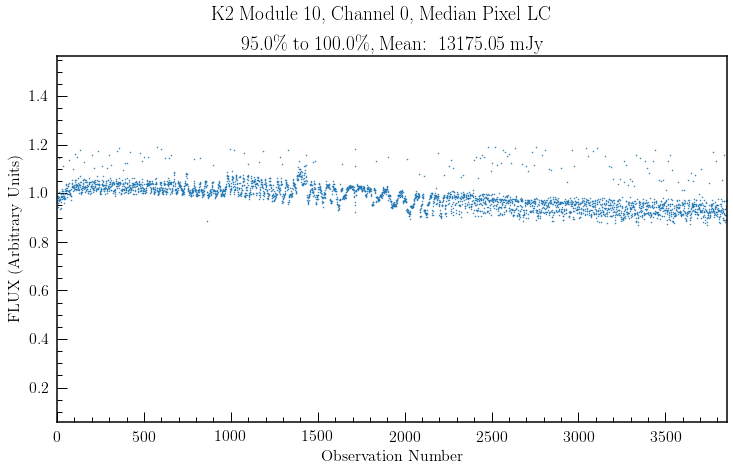

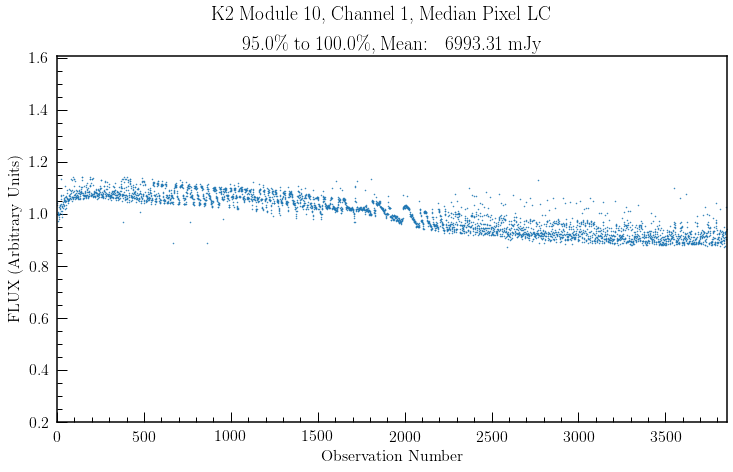

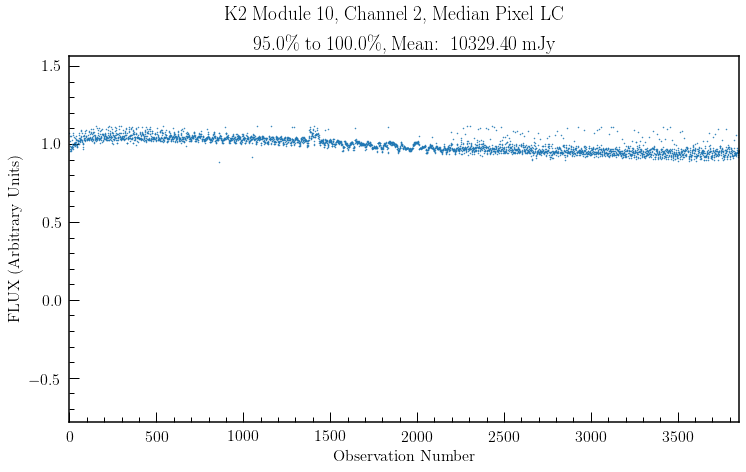

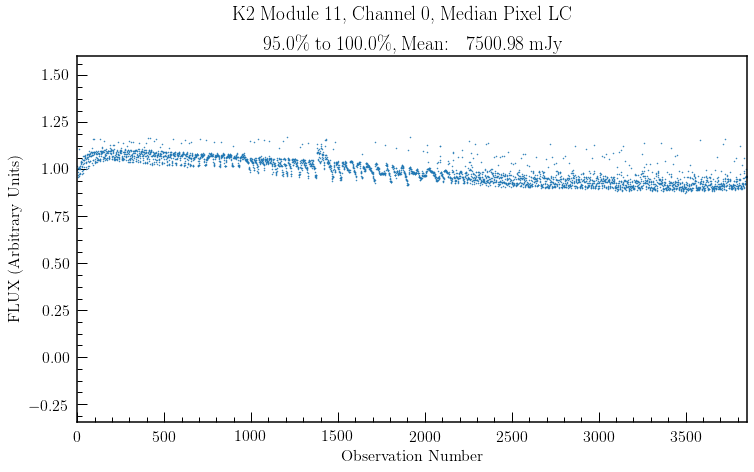

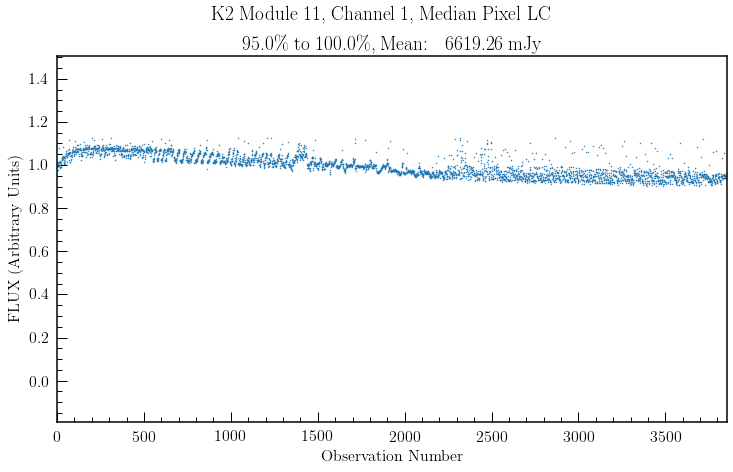

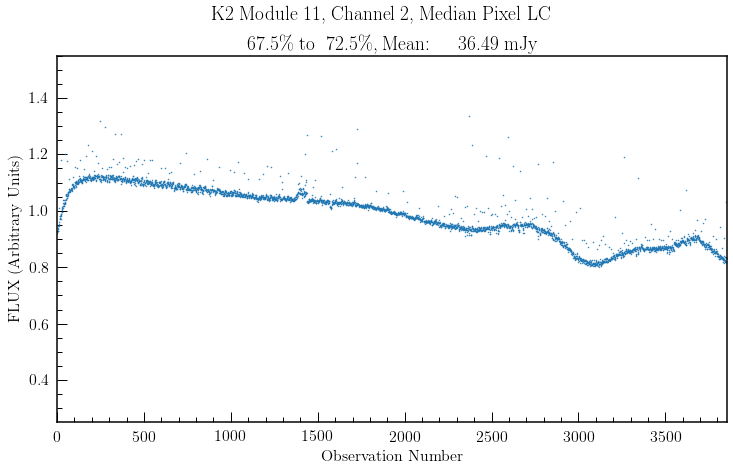

In [17]:
percentiles = smooth_percentile_range(20)
campaign = 8
for module in Field.get_modules():
    for channel in xrange(4):
        for field in ['FLUX']:
            ccd = CCD(campaign=campaign, field=field, channel=channel, module=module)
            print ccd
            if os.path.isfile("../plots/AnimatedLightCurves/"+make_pixel_map_name(ccd)+"_MedianLC.mp4"):
                print("  File Already Exists")
                continue
            objs = getObjects(ccd) # Dictionary of objects
            print "  Number of Objects:",len(objs.items())
            if objs:
                cont = load_pixel_map(ccd)
                gen=PixMapGenerator(cont)
                anim = make_lc_animation(gen, percentiles)
                print("  Saving...")
                with loader:
                    anim.save("../plots/AnimatedLightCurves/"+make_pixel_map_name(gen.ccd)+"_MedianLC.mp4")
            gc.collect()
            

In [101]:
print("Animating...")
with loader:
    HTML(anim.to_html5_video())
rc('animation', html='html5')
anim

Animating...
[|...........................................................] Estimating...    

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [94]:
print("Saving...")
with loader:
    anim.save("../plots/"+make_pixel_map_name(gen.ccd)+"_MedianLC.mp4")

Saving...
[#/..........................................................] Estimating...    

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


In [103]:
gc.collect()

5866

/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:879: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log10
/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


[/...........................................................] Estimating...    

/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


[#######-....................................................] 44:23 remaining  

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10


[#######|....................................................] 44:23 remaining  

/home/rodot/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


KeyboardInterrupt: 

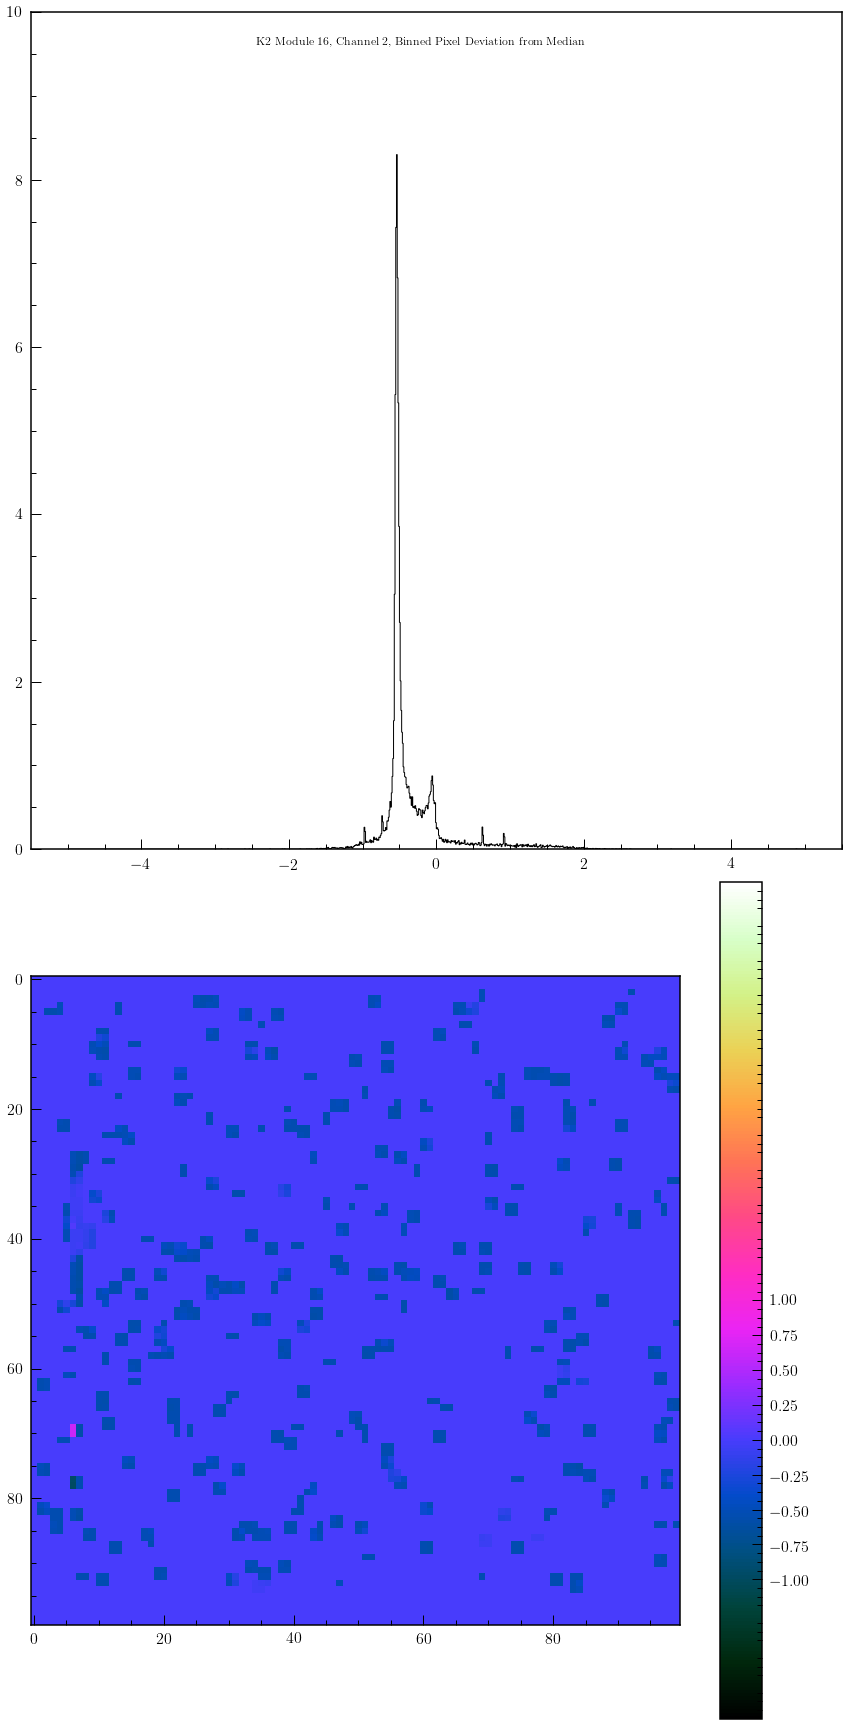

In [73]:
fig, ax = subplots(2,1, figsize=(12,24))
Blues = copy(cm.pink)
Blues.set_bad(color='black',alpha = 1.0)
cmap = palettable.colorbrewer.diverging.Spectral_11.mpl_colormap
cmap = palettable.cubehelix.cubehelix3_16.mpl_colormap
cmap.set_bad(color="#FFFFFF", alpha = 1.0)
# How should we go about scaling the pixel data?  This seems to work OK for now
#raw = gen[0]
#print "Base",cont[0].pixels[0]
#raw = gen.get_zscore(0)
#print "Raw",raw
#img = raw
#img=bin_pixel_buffer(raw, (20,20))
#print "img",img
#img[img<0] = np.nan
#img = np.log10(np.abs(raw*1.0))*np.sign(raw*1.0)


# The initial Draw
im = ax[1].imshow(np.zeros((100,100)), interpolation="None", cmap=cmap, vmin = -2, vmax = 4, animated=True)
cbar = fig.colorbar(im, ticks=[-1, -0.75,-0.5,-0.25, 0,0.25, 0.5,0.75,1])

#make the histogram
ax[0].hist([0], range=(-5,5), bins=1000, histtype='step', color='k', normed=True)


fig.suptitle("K2 Module %i, Channel %i, Binned Pixel Deviation from Median" % (ccd.module, ccd.channel))
fig.tight_layout()


def init():
    return update(0)

def update(i):

    loader.update_bar(1.0*i/N)
    i = i
    if i >= 3853:
        return im,
    #raw = gen[i]
    raw = gen.get_zscore(i)
    #raw = np.nanmean([gen.get_zscore(j) for j in xrange(i,i+5)], axis=0) #This is a smoothing
    img = bin_pixel_buffer(raw, (100,100))
    if not np.isnan(img).all():
        img[np.isnan(img)] = 0.0
        im.set_array(img)
    #print 1.0*i/N
    ax[0].clear()
    ax[0].hist(filter(lambda x: x,raw.flat), range=(-5,5), bins=1000, histtype='step', color='k', normed=True)
    ax[0].set_ylim(0,10)
    return im,
    
anim = animation.FuncAnimation(fig, update, frames=N, interval=50, blit=True)

with loader:
    HTML(anim.to_html5_video())

In [ ]:
# Run this cell to display the animation
rc('animation', html='html5')
anim



In [ ]:
# Or this one to save it
with loader:
    anim.save('../plots/RollingBandC%iChannel%i.mp4' % (ccd.campaign, ccd.channel))